# Содержание
1. [Постановка задачи](#first)  
   1.1 [Описание данных](#first_one)  
   1.2 [Чтение данных из файла](#first_two)
2. [Предобработка данных](#second)
3. [Анализ полученных данных](#third)  
   3.1 [Определение показателей разброса данных в параметре "выручка"](#third_one)
4. [Проверка гипотез](#fourth)
5. [Общие выводы](#fifth)

# Определение перспективного тарифа для телеком-компании

## Постановка задачи <a class="anchor" id="first"></a>

**Описание проекта**  
Федеральный оператор сотовой связи "Мегалайн" предлагает клиентам два тарифных плана: "Смарт" и "Ультра". 
Компании необходимо понять, какой тариф приносит ей больше прибыли.
Для этого необходимо провести предварительный анализ тарифов на выборке в 500 клиентов. Данные содержат следующую информацию о пользователях: ФИО, место проживания, выбранный тариф, количество звонков и сообщений за 2018 год.  
На основании анализа этих данных нужно сделать вывод какой тариф лучше. 

### Чтение данных из csv_файлов <a class="anchor" id="first_two"></a>

Прочитаем файлы из 4-х датасетов и соберем общую информацию:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math

In [2]:
#Информация о звонках каждого пользователя:
try:
    calls = pd.read_csv('/datasets/calls.csv')
except:
    calls = pd.read_csv('C:/Users/antig/Downloads/Яндекс Практикум/calls.csv')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [4]:
calls = calls.rename(columns={'call_date': 'date'})

In [5]:
#Округлим продолжительность в минутах до целого по правилам оператора:
calls['duration']=np.ceil(calls['duration'].astype(float))
calls.head()                         

,id,date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [6]:
calls['month'] = calls['date'].astype('datetime64[M]')
calls['month'] = calls['month'].dt.month
calls.head()

,id,date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [7]:
#Сгруппируем по количеству звонков и продолжительности в минутах:
calls_grouped = calls.groupby(['user_id', 'month']).agg(duration=('duration','sum'), date=('date', 'count'))
calls_grouped.reset_index()

,user_id,month,duration,date
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


In [8]:
#Переименуем столбец 'date' в столбец с информацией о количестве звонков 'call_number':
calls_grouped = calls_grouped.rename(columns={'date': 'call_number'})
calls_grouped.reset_index().head()

,user_id,month,duration,call_number
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


In [9]:
#Информация об использовании трафика пользователей:
try:
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
except:
    internet = pd.read_csv('C:/Users/antig/Downloads/Яндекс Практикум/internet.csv', index_col=0)
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [10]:
#Добавим столбцы с датой и месяцем использования интернета: 
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.dtypes
internet = internet.rename(columns={'session_date': 'date'})
internet['month'] = internet['date'].dt.month
internet.head()

,id,mb_used,date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [11]:
#Сгруппируем по пользователям и определим количество Мб, потраченных в каждёом месяце:
internet_grouped = internet.groupby(['user_id', 'month']).agg(mb_used=('mb_used','sum'))
internet_grouped = internet_grouped.reset_index()
internet_grouped.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [12]:
#Информация о сообщениях пользователей:
try:
    messages = pd.read_csv('/datasets/messages.csv')
except:
    messages = pd.read_csv('C:/Users/antig/Downloads/Яндекс Практикум/messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
# Добавим столбцы с датой и месяцем:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.dtypes
messages['month'] = messages['message_date'].dt.month
messages = messages.rename(columns={'message_date': 'date', 'id': 'msg_send'})
messages.head()

,msg_send,date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [14]:
# Сгруппируем по пользователям и посчитаем количество сообщений, отправленных в месяц:
messages_grouped = messages.groupby(['user_id', 'month']).agg(msg_send=('msg_send','count'))
messages_grouped = messages_grouped.reset_index()
messages_grouped.head()

,user_id,month,msg_send
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [15]:
# Объединим таблицы internet_grouped и messages_grouped:
int_msg = internet_grouped.merge(messages_grouped, on=['user_id', 'month'], how='outer')
int_msg = int_msg.reset_index()
int_msg.head()

,index,user_id,month,mb_used,msg_send
0,0,1000,5,2253.49,22.0
1,1,1000,6,23233.77,60.0
2,2,1000,7,14003.64,75.0
3,3,1000,8,14055.93,81.0
4,4,1000,9,14568.91,57.0


In [16]:
#Добавим в таблицу информацию о звонках:
int_msg_call = int_msg.merge(calls_grouped, on=['user_id', 'month'], how='outer')
int_msg_call = int_msg_call.reset_index()
int_msg_call.head()

,level_0,index,user_id,month,mb_used,msg_send,duration,call_number
0,0,0,1000,5,2253.49,22.0,159.0,22.0
1,1,1,1000,6,23233.77,60.0,172.0,43.0
2,2,2,1000,7,14003.64,75.0,340.0,47.0
3,3,3,1000,8,14055.93,81.0,408.0,52.0
4,4,4,1000,9,14568.91,57.0,466.0,58.0


In [17]:
#Заполним пропуски нулями:
int_msg_call['msg_send'] = int_msg_call['msg_send'].fillna(0)
int_msg_call['mb_used'] = int_msg_call['mb_used'].fillna(0)
int_msg_call['duration'] = int_msg_call['duration'].fillna(0)
int_msg_call.isna().sum()


level_0         0
index           0
user_id         0
month           0
mb_used         0
msg_send        0
duration        0
call_number    40
dtype: int64

In [18]:
#Общая информация о пользователях:
try:
    users = pd.read_csv('/datasets/users.csv')
except:
    users = pd.read_csv('C:/Users/antig/Downloads/Яндекс Практикум/users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
#Изменим тип данных в столбце reg_date:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.dtypes

user_id                int64
age                    int64
churn_date            object
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

In [20]:
#Объединим текущий датасет с датасетом int_msg_call:
users1 = users.merge(int_msg_call, on='user_id', how='outer')
users1.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,level_0,index,month,mb_used,msg_send,duration,call_number
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,5.0,2253.49,22.0,159.0,22.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1.0,6.0,23233.77,60.0,172.0,43.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,2.0,7.0,14003.64,75.0,340.0,47.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,3.0,8.0,14055.93,81.0,408.0,52.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,4.0,9.0,14568.91,57.0,466.0,58.0


In [21]:
#Общая информация о тарифах:
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('C:/Users/antig/Downloads/Яндекс Практикум/tariffs.csv')
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
#Переименуем столбец 'tariff_name' в датасете 'tariffs', чтобы можно было объединить по этому столбцу:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

In [23]:
#Объединим промежуточную таблицу users3 с датасетом tariffs:
df = users1.merge(tariffs, on='tariff', how='left')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             189 non-null    object        
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   level_0                3214 non-null   float64       
 9   index                  3214 non-null   float64       
 10  month                  3214 non-null   float64       
 11  mb_used                3214 non-null   float64       
 12  msg_send               3214 non-null   float64       
 13  dur

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,level_0,index,...,msg_send,duration,call_number,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,...,22.0,159.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1.0,...,60.0,172.0,43.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,2.0,...,75.0,340.0,47.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,3.0,...,81.0,408.0,52.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,4.0,...,57.0,466.0,58.0,1000,30720,3000,1950,150,1,1


## Предобработка данных <a class="anchor" id="second"></a>

Проверим полученный датасет на наличие ошибок, заполним пропуски, изменим типы данных.

In [24]:
#Определим количество пропусков в датасете:
df.isna().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
level_0                     2
index                       2
month                       2
mb_used                     2
msg_send                    2
duration                    2
call_number                42
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [25]:
df = df.dropna(subset=['month']).reset_index(drop=True)
df.isna().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
level_0                     0
index                       0
month                       0
mb_used                     0
msg_send                    0
duration                    0
call_number                40
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [26]:
#Удалим лишние столбцы level_0 и index:
df.drop(['level_0', 'index'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   age                    3214 non-null   int64         
 2   churn_date             187 non-null    object        
 3   city                   3214 non-null   object        
 4   first_name             3214 non-null   object        
 5   last_name              3214 non-null   object        
 6   reg_date               3214 non-null   datetime64[ns]
 7   tariff                 3214 non-null   object        
 8   month                  3214 non-null   float64       
 9   mb_used                3214 non-null   float64       
 10  msg_send               3214 non-null   float64       
 11  duration               3214 non-null   float64       
 12  call_number            3174 non-null   float64       
 13  mes

In [27]:
#Проверим какие типы данных есть в датасете:
df.dtypes

user_id                           int64
age                               int64
churn_date                       object
city                             object
first_name                       object
last_name                        object
reg_date                 datetime64[ns]
tariff                           object
month                           float64
mb_used                         float64
msg_send                        float64
duration                        float64
call_number                     float64
messages_included                 int64
mb_per_month_included             int64
minutes_included                  int64
rub_monthly_fee                   int64
rub_per_gb                        int64
rub_per_message                   int64
rub_per_minute                    int64
dtype: object

In [28]:
#Изменим тип данных в столбце 'mb_used' на целочисленный, так как, судя по описаниям тарифа, мегабайты необходимо будет переводить в гигабайты:
df['msg_send'] = df['msg_send'].astype('int')
df['duration'] = df['duration'].astype('int')
df['month'] = df['month'].astype('int')
df.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,msg_send,duration,call_number,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,22,159,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,60,172,43.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,75,340,47.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,81,408,52.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,57,466,58.0,1000,30720,3000,1950,150,1,1
5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,14702.49,73,350,57.0,1000,30720,3000,1950,150,1,1
6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,14756.47,58,338,43.0,1000,30720,3000,1950,150,1,1
7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,9817.61,70,333,46.0,1000,30720,3000,1950,150,1,1
8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,18429.34,0,430,59.0,50,15360,500,550,200,3,3
9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12,14036.66,0,414,63.0,50,15360,500,550,200,3,3


In [29]:
#Округлим мегабайты трафика до гигабайт:
df['gb_used'] = df['mb_used'] / 1024
df['gb_used']=np.ceil(df['gb_used'].astype(float))
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,...,duration,call_number,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,...,159,22.0,1000,30720,3000,1950,150,1,1,3.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,...,172,43.0,1000,30720,3000,1950,150,1,1,23.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,...,340,47.0,1000,30720,3000,1950,150,1,1,14.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,...,408,52.0,1000,30720,3000,1950,150,1,1,14.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,...,466,58.0,1000,30720,3000,1950,150,1,1,15.0


In [30]:
#Добавим столбец с количеством Гб, включенных в каждый тариф:
df['gb_per_month_included'] = df['mb_per_month_included'] / 1024
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,...,call_number,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,...,22.0,1000,30720,3000,1950,150,1,1,3.0,30.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,...,43.0,1000,30720,3000,1950,150,1,1,23.0,30.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,...,47.0,1000,30720,3000,1950,150,1,1,14.0,30.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,...,52.0,1000,30720,3000,1950,150,1,1,14.0,30.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,...,58.0,1000,30720,3000,1950,150,1,1,15.0,30.0


In [31]:
#Для расчет прибыли добавим в таблицу информацию о потраченных звонках, минутах и трафике:
df['gb_spend'] = (df['gb_used'] - df['gb_per_month_included']).clip(lower=0)
df['msg_spend'] = (df['msg_send'] - df['messages_included']).clip(lower=0)
df['minutes_spend'] = (df['duration'] - df['minutes_included']).clip(lower=0)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,gb_spend,msg_spend,minutes_spend
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,...,3000,1950,150,1,1,3.0,30.0,0.0,0,0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,...,3000,1950,150,1,1,23.0,30.0,0.0,0,0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,...,3000,1950,150,1,1,14.0,30.0,0.0,0,0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,...,3000,1950,150,1,1,14.0,30.0,0.0,0,0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,...,3000,1950,150,1,1,15.0,30.0,0.0,0,0


In [32]:
#Функция для расчета прибыли в зависимости от потраченных минут, трафика и сообщений:
def profit_calculation(row):
    gb_spend = row['gb_spend']
    msg_spend = row['msg_spend']
    minutes_spend = row['minutes_spend']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']
    rub_monthly_fee = row['rub_monthly_fee']
    result = (gb_spend * rub_per_gb) + (msg_spend * rub_per_message) + (minutes_spend * rub_per_minute) + rub_monthly_fee
    return result
df['profit'] = df.apply(profit_calculation, axis=1)
df.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,gb_spend,msg_spend,minutes_spend,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,...,1950,150,1,1,3.0,30.0,0.0,0,0,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,...,1950,150,1,1,23.0,30.0,0.0,0,0,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,...,1950,150,1,1,14.0,30.0,0.0,0,0,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,...,1950,150,1,1,14.0,30.0,0.0,0,0,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,...,1950,150,1,1,15.0,30.0,0.0,0,0,1950.0
5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,14702.49,...,1950,150,1,1,15.0,30.0,0.0,0,0,1950.0
6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,14756.47,...,1950,150,1,1,15.0,30.0,0.0,0,0,1950.0
7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,9817.61,...,1950,150,1,1,10.0,30.0,0.0,0,0,1950.0
8,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,18429.34,...,550,200,3,3,18.0,15.0,3.0,0,0,1150.0
9,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12,14036.66,...,550,200,3,3,14.0,15.0,0.0,0,0,550.0


## Анализ полученных данных <a class="anchor" id="third"></a>

Определим и проанализируем средние показатели использования трафика, сообщений и минут разговора для каждого пользователя в зависимости от тарифа, которым он пользуется.

In [33]:
#Выделим из основного датафрейма таблицу с необходимыми данными для анализа:
df_tariff = df[['user_id', 'month', 'tariff', 'gb_used', 'msg_send', 'duration']]
df_tariff.info()
df_tariff.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   3214 non-null   int64  
 1   month     3214 non-null   int32  
 2   tariff    3214 non-null   object 
 3   gb_used   3214 non-null   float64
 4   msg_send  3214 non-null   int32  
 5   duration  3214 non-null   int32  
dtypes: float64(1), int32(3), int64(1), object(1)
memory usage: 113.1+ KB


,user_id,month,tariff,gb_used,msg_send,duration
0,1000,5,ultra,3.0,22,159
1,1000,6,ultra,23.0,60,172
2,1000,7,ultra,14.0,75,340
3,1000,8,ultra,14.0,81,408
4,1000,9,ultra,15.0,57,466
5,1000,10,ultra,15.0,73,350
6,1000,11,ultra,15.0,58,338
7,1000,12,ultra,10.0,70,333
8,1001,11,smart,18.0,0,430
9,1001,12,smart,14.0,0,414


In [34]:
#Тариф "ultra":
df_tariff_ultra = df_tariff.query('tariff == "ultra"')
df_tariff_ultra.info()                      

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 3190
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   985 non-null    int64  
 1   month     985 non-null    int32  
 2   tariff    985 non-null    object 
 3   gb_used   985 non-null    float64
 4   msg_send  985 non-null    int32  
 5   duration  985 non-null    int32  
dtypes: float64(1), int32(3), int64(1), object(1)
memory usage: 42.3+ KB


In [35]:
#Тариф 'smart':
df_tariff_smart = df_tariff.query('tariff == "smart"')
df_tariff_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2229 non-null   int64  
 1   month     2229 non-null   int32  
 2   tariff    2229 non-null   object 
 3   gb_used   2229 non-null   float64
 4   msg_send  2229 non-null   int32  
 5   duration  2229 non-null   int32  
dtypes: float64(1), int32(3), int64(1), object(1)
memory usage: 95.8+ KB


Построим гистограммы распределения для всех параметров тарифов Smart и Ultra: трафик, звонки, сообщения.

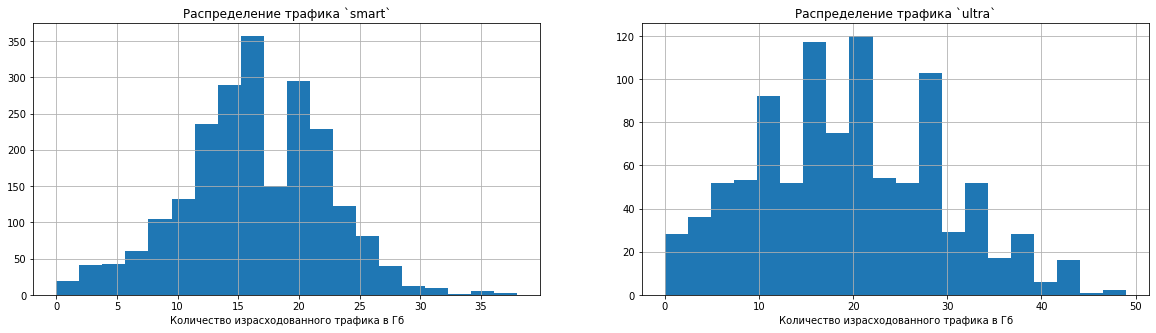

In [36]:
#Гистограммы распределения используемого трафика в Гб:
fig, axes = plt.subplots(1,2,figsize=(20,5))

df_tariff_smart['gb_used'].hist(bins=20, ax=axes[0])
axes[0].set_xlabel("Количество израсходованного трафика в Гб")

df_tariff_ultra['gb_used'].hist(bins=20, ax=axes[1])
axes[1].set_xlabel("Количество израсходованного трафика в Гб")

axes[0].set_title('Распределение трафика `smart`')
axes[1].set_title('Распределение трафика `ultra`')


plt.show()

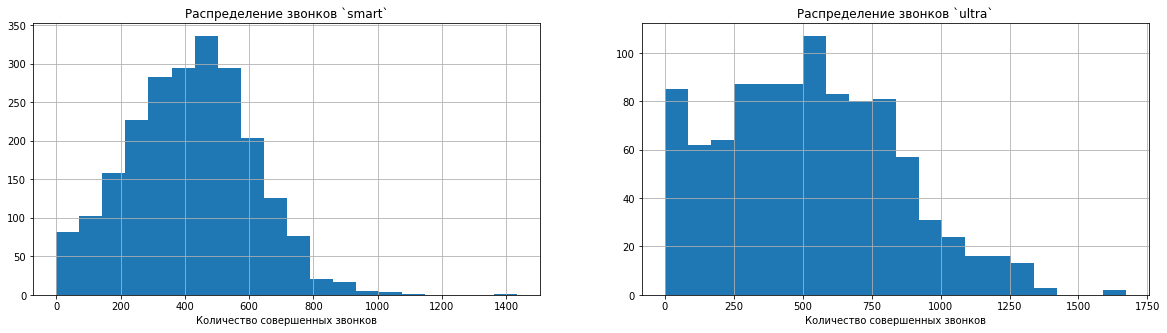

In [37]:
#Гистограммы распределения совершенных звонков:
fig, axes = plt.subplots(1,2,figsize=(20,5))

df_tariff_smart['duration'].hist(bins=20, ax=axes[0])
axes[0].set_xlabel("Количество совершенных звонков")

df_tariff_ultra['duration'].hist(bins=20, ax=axes[1])
axes[1].set_xlabel("Количество совершенных звонков")

axes[0].set_title('Распределение звонков `smart`')
axes[1].set_title('Распределение звонков `ultra`')


plt.show()

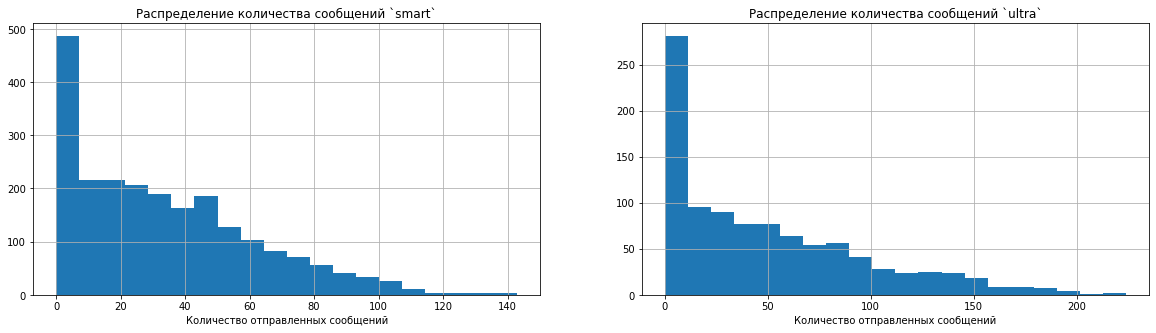

In [38]:
# Гистограммы распределения количества сообщений:
fig, axes = plt.subplots(1,2,figsize=(20,5))

df_tariff_smart['msg_send'].hist(bins=20, ax=axes[0])
axes[0].set_xlabel("Количество отправленных сообщений")

df_tariff_ultra['msg_send'].hist(bins=20, ax=axes[1])
axes[1].set_xlabel("Количество отправленных сообщений")

axes[0].set_title('Распределение количества сообщений `smart`')
axes[1].set_title('Распределение количества сообщений `ultra`')


plt.show()

In [39]:
#Посчитаем дисперсию и стандартное отклонение для всех параметров по двум тарифам:
df_tariff_pivot = df_tariff.pivot_table(index='tariff', 
                                        values=['gb_used', 'msg_send', 'duration'], 
                                        aggfunc=['var', 'std'])
df_tariff_pivot

var                                 std                     
             duration    gb_used     msg_send    duration   gb_used   msg_send
tariff                                                                        
smart    36219.315784  33.028705   796.812958  190.313730  5.747061  28.227876
ultra   100873.633397  97.091686  2285.266143  317.606098  9.853511  47.804457

**Вывод:** Гистограммы распределения значений для тарифов "Ультра" и "Смарт" имеют схожий характер: распределения значений трафика и звонков близки к нормальному распределению, а распределение сообщений имеет скошенность вправо. Стандартное отклонение и дисперсия для этих значений показывают, что наименьший разброс имеют значения израсходованного трафика для обоих тарифов ('gb_used'), значения же количества совершенных звонков и отправленных сообщений слишком "разбросаны" относительно средних значений этих параметров.

### Определение показателей разброса данных в параметре "выручка" <a class="anchor" id="third_one"></a>

Для расчета показателей прибыли среднее значение, дисперсия и стандартное отклонение соберем данные из основного датасета df: 

In [40]:
df_profit = df[['month', 'tariff', 'profit']]
df_profit.head()

,month,tariff,profit
0,5,ultra,1950.0
1,6,ultra,1950.0
2,7,ultra,1950.0
3,8,ultra,1950.0
4,9,ultra,1950.0


In [41]:
#С помощью срезов разделим датафрейм на два в зависимости от тарифа:
df_profit_ultra = df_profit.query('tariff == "ultra"')
#df_profit_ultra.info()
df_profit_ultra.head()

,month,tariff,profit
0,5,ultra,1950.0
1,6,ultra,1950.0
2,7,ultra,1950.0
3,8,ultra,1950.0
4,9,ultra,1950.0


In [42]:
df_profit_smart = df_profit.query('tariff == "smart"')
#df_profit_smart.info()
df_profit_smart.head()

,month,tariff,profit
8,11,smart,1150.0
9,12,smart,550.0
10,6,smart,550.0
11,7,smart,1150.0
12,8,smart,1550.0


In [43]:
#Посчитаем дисперсию и стандартное отклонение для всех параметров по двум тарифам:
df_profit_pivot = df_profit.pivot_table(index='tariff', 
                                        values=['profit'], 
                                        aggfunc=['mean', 'std'])
df_profit_pivot

,mean,std
,profit,profit
tariff,,
smart,1289.973531,818.404367
ultra,2070.152284,376.187114


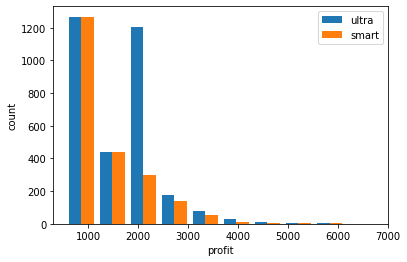

In [44]:
#Построим гистограммы для показателя "выручка" в зависимости от тарифа:
plt.hist([df_profit['profit'], df_profit_smart['profit']], bins=10, label=['ultra', 'smart'])
plt.legend(loc='upper right')
plt.xlabel('profit')
plt.ylabel('count')
plt.show()

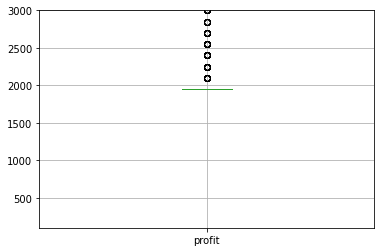

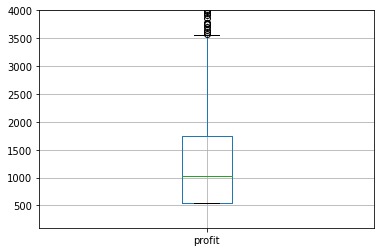

In [45]:
#Для проверки предположения о разбросе построим диаграммы размаха для выручки по каждому тарифу:
df_1 = df_profit_ultra[['profit']]
df_1.boxplot()
plt.ylim(100,3000)
plt.show()
df_2 = df_profit_smart[['profit']]
df_2.boxplot()
plt.ylim(100, 4000)
plt.show()

**Вывод:** На обеих гистограммах наблюдается скошенность значений вправо, что подтверждают построенные ниже диаграммы размаха, на которых видно смещение медианы относительно среднего значения.Средняя выручка пользователей тарифа "Ультра" составляет 2070 руб при абонентской плате 1950 руб в месяц, а для тарифа "Смарт" средняя выручка- около 1290 руб при абонентской плате 550 руб в месяц.  
Величина стандартного отклонения для тарифа "Ультра"- 376,2, для тарифа "Смарт" - 818,4. На основании этого можно сделать предположение о том, что данные по выручке для тарифа Смарт больше разбросаны относительно среднего значения выручки, чем значения выручки для тарифа Ультра.

## Проверка гипотез <a class="anchor" id="fourth"></a>

Проверим следующие гипотезы:  
-средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;  
-средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [46]:
#Создадим два массива с данными выручки для тарифов "Ультра" и "Смарт":
ultra = df_profit_ultra['profit'].to_numpy()
#len(ultra)
#ultra
smart = df_profit_smart['profit'].to_numpy()
#smart

**Нулевая гипотеза H0**: Средние значения выручек от пользователей тарифов "Ультра" и "Смарт" равны.  
**Альтернативная гипотеза H1:**: Средние значения выручек от пользователей тарифов "Ультра" и "Смарт" не равны и средняя выручка по одному тарифу больше, чем средняя выручка по другому.

In [47]:
#Проверим первую гипотезу о неравенстве средних выручек по тарифам "Ультра" и "Смарт".
#Для проверки используем метод st.ttest_ind:
alpha = 0.05
results = st.ttest_ind(ultra, smart)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
if ultra.mean() > smart.mean():
    print('Среднее значение выручки по тарифу "Ультра" больше:', ultra.mean(), '>', smart.mean())
else:
    print('Среднее значение выручки по тарифу "Смарт" больше:', smart.mean(), '>', ultra.mean())

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу
Среднее значение выручки по тарифу "Ультра" больше: 2070.1522842639592 > 1289.9735307312696


Для проверки второй гипотезы необходимо сначала разделить всех пользователей на пользователей, живущих в Москве и пользователей, живущих в других городах.

In [48]:
#Выделим из основного датасета df датафрейм с информацией о городах проживания абонентов, тарифах
#и выручке с каждого пользователя:
df_city = df[['user_id', 'tariff', 'city', 'profit']]
#df_city.head()
#Выделим пользователей Москвы, использующих тариф "Ультра":
#df_moscow_ultra = df_city.query('city == "Москва" and tariff == "ultra"')
df_moscow = df_city.query('city == "Москва"') 
df_moscow['profit'].describe()

count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: profit, dtype: float64

In [49]:
#Выделим пользователей живущих в других городах и разделим их по используемым тарифам:

df_others = df_city.query('city != "Москва"')
df_others['profit'].describe()

count    2603.000000
mean     1524.936227
std       808.787752
min       550.000000
25%       750.000000
50%      1583.000000
75%      1950.000000
max      6770.000000
Name: profit, dtype: float64

In [50]:
#Создадим массивы со значениями выручки от пользователей Москвы и от пользователей других городов:
moscow = df_moscow['profit'].to_numpy()
others = df_others['profit'].to_numpy()

**Нулевая гипотеза H0**: средние выручки от пользователей Москвы и других городов для каждого тарифа равны.  
**Альтернативная гипотеза H1:** средние выручки от жителей Москвы и пользователей других городов для каждого тарифа не равны.

In [51]:
#Проверим вторую гипотезу:
#Для тарифа "Ультра"
alpha = 0.05
results2 = st.ttest_ind(moscow, others, equal_var=True)
print('p-значение:', results2.pvalue)
if (results2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
if moscow.mean() > others.mean():
    print('Среднее значение выручки от жителей Москвы, использующих тариф "Ультра", больше, чем от пользователей этого тарифа в других городах:',
          moscow.mean(), '>', others.mean())
else:
    print('Среднее значение выручки от жителей других городов больше, чем от жителей Москвы:',  
          others.mean(), '>', moscow.mean())

p-значение: 0.5440152911670223
Не получилось отвергнуть нулевую гипотезу
Среднее значение выручки от жителей Москвы, использующих тариф "Ультра", больше, чем от пользователей этого тарифа в других городах: 1546.7135842880523 > 1524.9362274298885


**Вывод:** Средняя выручка от всех пользователей тарифа "Ультра" больше выручки от всех пользователей тарифа "Смарт".  
Средняя выручка от абонентов Москвы по тарифу "Ультра" больше средней выручки от абонентов других городов, а для тарифа "Смарт", наоборот:средняя выручка от жителей других городов больше,чем от жителей Москвы.  
Полученные значения p-value в ходе расчетов для жителей разных городов и Москвы говорят о том, что несмотря на то, что средние значения выручек разных городов различаются, эти различия могли получиться случайно. То есть, это не слишком значимые различия.

## Общие выводы <a class="anchor" id="fifth"></a>

В ходе исследований тарифов "Смарт" и "Ультра" оператора сотовой сети "Мегалайн" были сделаны следующие выводы:  
1. Большее число абонентов из выборки в 500 человек пользуются тарифом "Смарт".  
2. Большую выручку компания "Мегалайн" получает от пользователей тарифа "Ультра": в среднем 2071 руб с человека против средней выручки 1289 руб от тарифа "Смарт".  
3. Выручка с каждого пользователя зависит от количества израсходованных им пакетов услуг и от размера абонентской платы в месяц: например,если пользователь не использовал весь пакет предоставляемого бесплатного трафика, но при этом полностью заплатил абонентскую плату, то выручка для оператора увеличивается.  
4. Более перспективным для оператора является тариф "Смарт", так как абонентская плата по этому тарифу ниже,чем по тарифу "Ультра", что привлекает большее количество пользователей. Но при этом многие из них превышают установленные лимиты по пакетам услуг и продолжают ими пользоваться уже сверх абонентской платы. Как вариант, таким клиентам можно предложить дополнительные пакеты услуг за определенную плату. 